# Step 1: Get Tables into dfs

In [1]:
import pandas as pd
import re
from ast import literal_eval

# === Load the raw SQL from files ===
with open("assignment_history SQL Table.txt", "r") as f:
    assignment_raw = f.read()

with open("bookings SQL Table.txt", "r") as f:
    bookings_raw = f.read()

with open("space_travel_agents SQL Table.txt", "r") as f:
    agents_raw = f.read()

# === Improved parsing function ===
def parse_sql_values_block(raw_sql: str) -> list:
    matches = re.findall(r"VALUES\s*(.*?);", raw_sql, re.DOTALL)
    if not matches:
        return []
    values_str = matches[0].replace("NULL", "None")
    
    # Split by row safely, accounting for nested commas
    tuple_strings = re.findall(r"\((.*?)\)", values_str, re.DOTALL)
    
    parsed = []
    for t in tuple_strings:
        try:
            parsed.append(literal_eval(f"({t})"))
        except Exception as e:
            print("Failed to parse:", t)
            print("Error:", e)
    return parsed

# === Column definitions ===
assignment_columns = ['AssignmentID', 'AgentID', 'CustomerName', 'CommunicationMethod', 'LeadSource', 'AssignedDateTime']
bookings_columns = ['BookingID', 'AssignmentID', 'BookingCompleteDate', 'CancelledDate', 'Destination', 'Package', 'LaunchLocation', 'DestinationRevenue', 'PackageRevenue', 'TotalRevenue', 'BookingStatus']
agents_columns = ['AgentID', 'FirstName', 'LastName', 'Email', 'JobTitle', 'DepartmentName', 'ManagerName', 'SpaceLicenseNumber', 'YearsOfService', 'AverageCustomerServiceRating']

# === Parse and convert to DataFrames ===
df_assignment = pd.DataFrame(parse_sql_values_block(assignment_raw), columns=assignment_columns)
df_bookings = pd.DataFrame(parse_sql_values_block(bookings_raw), columns=bookings_columns)
df_agents = pd.DataFrame(parse_sql_values_block(agents_raw), columns=agents_columns)

In [2]:
df_bookings.head()

,BookingID,AssignmentID,BookingCompleteDate,CancelledDate,Destination,Package,LaunchLocation,DestinationRevenue,PackageRevenue,TotalRevenue,BookingStatus
0,1,1,2081-02-01 10:00:00,None,Mars,Luxury Dome Stay,Dallas-Fort Worth Launch Complex,150000,25000,175000,Confirmed
1,2,2,None,2081-02-01 11:00:00,Europa,Zero-Gravity Yacht Cruise,New York Orbital Gateway,120000,20000,140000,Cancelled
2,3,4,2081-02-01 13:30:00,None,Titan,Ringside Cruise,Dubai Interplanetary Hub,140000,30000,170000,Confirmed
3,4,5,None,2081-02-01 15:10:00,Mars,Luxury Dome Stay,Dallas-Fort Worth Launch Complex,150000,25000,175000,Cancelled
4,5,6,2081-02-02 10:00:00,None,Venus,Cloud City Excursion,Tokyo Spaceport Terminal,130000,25000,155000,Confirmed


# 1. Observe all column names

In [3]:
print("assignment_history columns:", df_assignment.columns.tolist())
print("bookings columns:", df_bookings.columns.tolist())
print("space_travel_agents columns:", df_agents.columns.tolist())

assignment_history columns: ['AssignmentID', 'AgentID', 'CustomerName', 'CommunicationMethod', 'LeadSource', 'AssignedDateTime']
bookings columns: ['BookingID', 'AssignmentID', 'BookingCompleteDate', 'CancelledDate', 'Destination', 'Package', 'LaunchLocation', 'DestinationRevenue', 'PackageRevenue', 'TotalRevenue', 'BookingStatus']
space_travel_agents columns: ['AgentID', 'FirstName', 'LastName', 'Email', 'JobTitle', 'DepartmentName', 'ManagerName', 'SpaceLicenseNumber', 'YearsOfService', 'AverageCustomerServiceRating']


# 2. Observe all categorical features

In [4]:
# Assignment-level categorical features
print("CommunicationMethod:", df_assignment['CommunicationMethod'].unique())
print("LeadSource:", df_assignment['LeadSource'].unique())

# Booking-level categorical features
print("Destination:", df_bookings['Destination'].unique())
print("LaunchLocation:", df_bookings['LaunchLocation'].unique())
print("Package:", df_bookings['Package'].unique())

# Agent-level optional features
print("JobTitle:", df_agents['JobTitle'].unique())
print("DepartmentName:", df_agents['DepartmentName'].unique())

CommunicationMethod: ['Phone Call' 'Text']
LeadSource: ['Organic' 'Bought']
Destination: ['Mars' 'Europa' 'Titan' 'Venus' 'Ganymede']
LaunchLocation: ['Dallas-Fort Worth Launch Complex' 'New York Orbital Gateway'
 'Dubai Interplanetary Hub' 'Tokyo Spaceport Terminal'
 'London Ascension Platform' 'Sydney Stellar Port']
Package: ['Luxury Dome Stay' 'Zero-Gravity Yacht Cruise' 'Ringside Cruise'
 'Cloud City Excursion' 'Glacier Trek Adventure'
 'Private Observatory Suite']
JobTitle: ['Senior Space Travel Agent' 'Space Travel Agent'
 'Lead Space Travel Agent']
DepartmentName: ['Interplanetary Sales' 'Luxury Voyages' 'Premium Bookings']


In [5]:
import sqlite3

# Recreate the in-memory database
conn = sqlite3.connect(":memory:")

# Write the dataframes into the database
df_assignment.to_sql("assignment_history", conn, index=False)
df_bookings.to_sql("bookings", conn, index=False)
df_agents.to_sql("space_travel_agents", conn, index=False)

30

# 2. Modeling: Agent Ranking System

In [6]:
def build_agent_ranking_query(customer):
    return f"""
    WITH confirmed_bookings AS (
      SELECT
        a.AgentID,
        COUNT(*) AS TotalAssignments,
        SUM(CASE WHEN b.BookingStatus = 'Confirmed' THEN 1 ELSE 0 END) AS Confirmed,
        AVG(CASE WHEN b.BookingStatus = 'Confirmed' THEN b.TotalRevenue ELSE NULL END) AS AvgRevenue,

        -- Match logic using real customer input
        SUM(CASE WHEN a.CommunicationMethod = '{customer["CommunicationMethod"]}' THEN 1 ELSE 0 END) AS Match_CommMethod,
        SUM(CASE WHEN a.LeadSource = '{customer["LeadSource"]}' THEN 1 ELSE 0 END) AS Match_LeadSource,
        SUM(CASE WHEN b.Destination = '{customer["Destination"]}' THEN 1 ELSE 0 END) AS Match_Destination,
        SUM(CASE WHEN b.LaunchLocation = '{customer["LaunchLocation"]}' THEN 1 ELSE 0 END) AS Match_Launch,
        SUM(CASE WHEN b.Package = '{customer["Package"]}' THEN 1 ELSE 0 END) AS Match_Package
      FROM assignment_history a
      JOIN bookings b ON a.AssignmentID = b.AssignmentID
      GROUP BY a.AgentID
    ),
    scored AS (
      SELECT
        cb.AgentID,
        s.AverageCustomerServiceRating,
        cb.Confirmed * 1.0 / NULLIF(cb.TotalAssignments, 0) AS SuccessRate,
        cb.AvgRevenue,
        (Match_CommMethod + Match_LeadSource + Match_Destination + Match_Launch + Match_Package) AS MatchScore
      FROM confirmed_bookings cb
      JOIN space_travel_agents s ON cb.AgentID = s.AgentID
    ),
    normalized AS (
      SELECT
        AgentID,
        SuccessRate,
        AvgRevenue,
        AverageCustomerServiceRating,
        MatchScore,
        1.0 * SuccessRate / (SELECT MAX(SuccessRate) FROM scored) AS Norm_Success,
        1.0 * AvgRevenue / (SELECT MAX(AvgRevenue) FROM scored) AS Norm_Revenue,
        1.0 * AverageCustomerServiceRating / 10.0 AS Norm_Rating,
        1.0 * MatchScore / (
    SELECT MAX(MatchScore) FROM scored
) AS Norm_Match
      FROM scored
    )
    SELECT
      AgentID,
      ROUND(0.25 * Norm_Success + 0.20 * Norm_Revenue + 0.20 * Norm_Rating + 0.35 * Norm_Match, 3) AS CompositeScore,
      ROUND(Norm_Success, 3) AS Norm_Success,
      ROUND(Norm_Revenue, 3) AS Norm_Revenue,
      ROUND(Norm_Rating, 3) AS Norm_Rating,
      ROUND(Norm_Match, 3) AS Norm_Match
    FROM normalized
    ORDER BY CompositeScore DESC
    LIMIT 1;
    """

# 3. Generate Fake Customers

In [7]:
import random

communication_methods = ['Phone Call', 'Text']
lead_sources = ['Organic', 'Bought']
destinations = ['Mars', 'Europa', 'Titan', 'Venus', 'Ganymede']
launch_locations = [
    'Dallas-Fort Worth Launch Complex',
    'New York Orbital Gateway',
    'Dubai Interplanetary Hub',
    'Tokyo Spaceport Terminal',
    'London Ascension Platform',
    'Sydney Stellar Port'
]
packages = [
    'Luxury Dome Stay',
    'Zero-Gravity Yacht Cruise',
    'Ringside Cruise',
    'Cloud City Excursion',
    'Glacier Trek Adventure',
    'Private Observatory Suite'
]

def generate_fake_customers(n=100):
    customers = []
    for _ in range(n):
        customer = {
            "CommunicationMethod": random.choice(communication_methods),
            "LeadSource": random.choice(lead_sources),
            "Destination": random.choice(destinations),
            "LaunchLocation": random.choice(launch_locations),
            "Package": random.choice(packages)
        }
        customers.append(customer)
    return customers

fake_customers = generate_fake_customers(100)
fake_customers[:5]  # Show first 5

[{'CommunicationMethod': 'Phone Call',
  'LeadSource': 'Bought',
  'Destination': 'Mars',
  'LaunchLocation': 'Tokyo Spaceport Terminal',
  'Package': 'Ringside Cruise'},
 {'CommunicationMethod': 'Text',
  'LeadSource': 'Bought',
  'Destination': 'Europa',
  'LaunchLocation': 'New York Orbital Gateway',
  'Package': 'Ringside Cruise'},
 {'CommunicationMethod': 'Phone Call',
  'LeadSource': 'Bought',
  'Destination': 'Europa',
  'LaunchLocation': 'Sydney Stellar Port',
  'Package': 'Zero-Gravity Yacht Cruise'},
 {'CommunicationMethod': 'Phone Call',
  'LeadSource': 'Organic',
  'Destination': 'Europa',
  'LaunchLocation': 'Sydney Stellar Port',
  'Package': 'Glacier Trek Adventure'},
 {'CommunicationMethod': 'Text',
  'LeadSource': 'Bought',
  'Destination': 'Titan',
  'LaunchLocation': 'Sydney Stellar Port',
  'Package': 'Glacier Trek Adventure'}]

# 4. Evaluate Model

In [8]:
results = []

for i, customer in enumerate(fake_customers, start=1):
    try:
        query = build_agent_ranking_query(customer)
        row = pd.read_sql_query(query, conn).iloc[0]  # top agent
        results.append({
            "Customer #": i,
            **customer,
            "TopAgentID": row["AgentID"],
            "CompositeScore": row["CompositeScore"],
            "Norm_Success": row["Norm_Success"],
            "Norm_Revenue": row["Norm_Revenue"],
            "Norm_Rating": row["Norm_Rating"],
            "Norm_Match": row["Norm_Match"]
        })
    except Exception as e:
        print(f"Error on customer {i}: {e}")

In [9]:
df_results = pd.DataFrame(results)
df_results.head(100)

,Customer #,CommunicationMethod,LeadSource,Destination,LaunchLocation,Package,TopAgentID,CompositeScore,Norm_Success,Norm_Revenue,Norm_Rating,Norm_Match
0,1,Phone Call,Bought,Mars,Tokyo Spaceport Terminal,Ringside Cruise,3.0,0.839,0.864,0.963,0.40,1.00
1,2,Text,Bought,Europa,New York Orbital Gateway,Ringside Cruise,19.0,0.827,0.917,0.767,0.47,1.00
2,3,Phone Call,Bought,Europa,Sydney Stellar Port,Zero-Gravity Yacht Cruise,6.0,0.830,0.825,0.910,0.46,1.00
3,4,Phone Call,Organic,Europa,Sydney Stellar Port,Glacier Trek Adventure,6.0,0.830,0.825,0.910,0.46,1.00
4,5,Text,Bought,Titan,Sydney Stellar Port,Glacier Trek Adventure,19.0,0.827,0.917,0.767,0.47,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,Phone Call,Bought,Venus,London Ascension Platform,Zero-Gravity Yacht Cruise,23.0,0.837,0.807,0.925,0.50,1.00
96,97,Text,Organic,Mars,New York Orbital Gateway,Glacier Trek Adventure,19.0,0.827,0.917,0.767,0.47,1.00
97,98,Text,Organic,Ganymede,London Ascension Platform,Cloud City Excursion,13.0,0.796,0.688,0.941,0.43,1.00
98,99,Phone Call,Organic,Europa,Dallas-Fort Worth Launch Complex,Private Observatory Suite,7.0,0.818,0.756,0.947,0.45,1.00


In [10]:
avg_score = df_results["CompositeScore"].mean()
print(f"Average Composite Score: {avg_score:.3f}")

Average Composite Score: 0.822


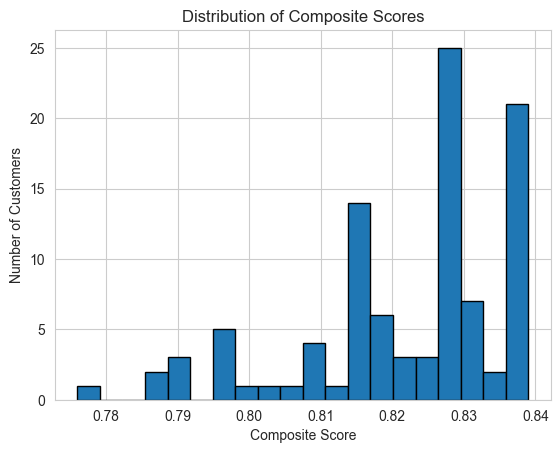

In [11]:
import matplotlib.pyplot as plt

plt.hist(df_results["CompositeScore"], bins=20, edgecolor='black')
plt.title("Distribution of Composite Scores")
plt.xlabel("Composite Score")
plt.ylabel("Number of Customers")
plt.show()

In [12]:
df_results["TopAgentID"].value_counts().head(5)

TopAgentID
19.0    24
3.0     19
27.0    13
6.0      8
25.0     7
Name: count, dtype: int64

In [13]:
# Join on AssignmentID to get customer-level info
bookings_enriched = df_bookings.merge(
    df_assignment[["AssignmentID", "CommunicationMethod", "LeadSource"]],
    on="AssignmentID",
    how="left"
)

# Filter to confirmed bookings only
bookings_enriched = bookings_enriched[bookings_enriched["BookingStatus"] == "Confirmed"]

# Optional: drop any rows with missing values in key columns
bookings_enriched = bookings_enriched.dropna(subset=[
    "CommunicationMethod", "LeadSource", "Destination", "LaunchLocation", "Package"
])

In [14]:
results = []

for i, row in bookings_enriched.iterrows():
    customer = {
        "CommunicationMethod": row["CommunicationMethod"],
        "LeadSource": row["LeadSource"],
        "Destination": row["Destination"],
        "LaunchLocation": row["LaunchLocation"],
        "Package": row["Package"]
    }

    try:
        query = build_agent_ranking_query(customer)
        top_agent = pd.read_sql_query(query, conn).iloc[0]
        results.append({
            "BookingID": row["BookingID"],
            **customer,
            "TopAgentID": top_agent["AgentID"],
            "CompositeScore": top_agent["CompositeScore"],
            "Norm_Success": top_agent["Norm_Success"],
            "Norm_Revenue": top_agent["Norm_Revenue"],
            "Norm_Rating": top_agent["Norm_Rating"],
            "Norm_Match": top_agent["Norm_Match"]
        })
    except Exception as e:
        print(f"Error on BookingID {row['BookingID']}: {e}")

In [15]:
df_booking_results = pd.DataFrame(results)
df_booking_results.head(400)

,BookingID,CommunicationMethod,LeadSource,Destination,LaunchLocation,Package,TopAgentID,CompositeScore,Norm_Success,Norm_Revenue,Norm_Rating,Norm_Match
0,1,Phone Call,Organic,Mars,Dallas-Fort Worth Launch Complex,Luxury Dome Stay,28.0,0.844,0.786,1.000,0.49,1.000
1,3,Phone Call,Bought,Titan,Dubai Interplanetary Hub,Ringside Cruise,11.0,0.823,0.953,0.760,0.47,0.969
2,5,Phone Call,Bought,Venus,Tokyo Spaceport Terminal,Cloud City Excursion,23.0,0.837,0.807,0.925,0.50,1.000
3,6,Phone Call,Organic,Mars,New York Orbital Gateway,Luxury Dome Stay,28.0,0.844,0.786,1.000,0.49,1.000
4,8,Phone Call,Organic,Ganymede,Sydney Stellar Port,Private Observatory Suite,15.0,0.824,0.825,0.928,0.41,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...
292,407,Text,Organic,Titan,New York Orbital Gateway,Ringside Cruise,27.0,0.816,0.894,0.815,0.40,1.000
293,409,Phone Call,Organic,Venus,Dubai Interplanetary Hub,Cloud City Excursion,25.0,0.791,1.000,0.941,0.44,0.757
294,410,Text,Bought,Mars,Dallas-Fort Worth Launch Complex,Luxury Dome Stay,19.0,0.827,0.917,0.767,0.47,1.000
295,411,Text,Organic,Titan,New York Orbital Gateway,Ringside Cruise,27.0,0.816,0.894,0.815,0.40,1.000


In [16]:
avg_score = df_results["CompositeScore"].mean()
print(f"Average Composite Score: {avg_score:.3f}")

Average Composite Score: 0.822


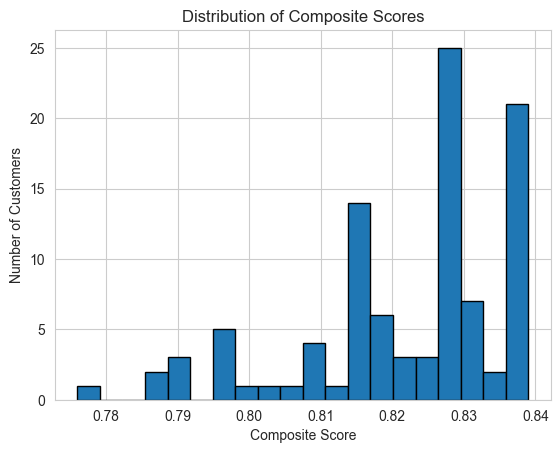

In [17]:
import matplotlib.pyplot as plt

plt.hist(df_results["CompositeScore"], bins=20, edgecolor='black')
plt.title("Distribution of Composite Scores")
plt.xlabel("Composite Score")
plt.ylabel("Number of Customers")
plt.show()

# Grid Search

In [18]:
import itertools

def generate_weight_combinations(step=0.1):
    weights = [round(i, 2) for i in np.arange(0, 1.01, step)]
    combos = []
    for w in itertools.product(weights, repeat=4):
        if abs(sum(w) - 1.0) < 1e-6:
            combos.append({
                "w_success": w[0],
                "w_revenue": w[1],
                "w_rating": w[2],
                "w_match": w[3]
            })
    return combos



In [19]:
def build_agent_ranking_query(customer, w_success, w_revenue, w_rating, w_match):
    return f"""
    WITH confirmed_bookings AS (
      SELECT
        a.AgentID,
        COUNT(*) AS TotalAssignments,
        SUM(CASE WHEN b.BookingStatus = 'Confirmed' THEN 1 ELSE 0 END) AS Confirmed,
        AVG(CASE WHEN b.BookingStatus = 'Confirmed' THEN b.TotalRevenue ELSE NULL END) AS AvgRevenue,

        -- Match logic using real customer input
        SUM(CASE WHEN a.CommunicationMethod = '{customer["CommunicationMethod"]}' THEN 1 ELSE 0 END) AS Match_CommMethod,
        SUM(CASE WHEN a.LeadSource = '{customer["LeadSource"]}' THEN 1 ELSE 0 END) AS Match_LeadSource,
        SUM(CASE WHEN b.Destination = '{customer["Destination"]}' THEN 1 ELSE 0 END) AS Match_Destination,
        SUM(CASE WHEN b.LaunchLocation = '{customer["LaunchLocation"]}' THEN 1 ELSE 0 END) AS Match_Launch,
        SUM(CASE WHEN b.Package = '{customer["Package"]}' THEN 1 ELSE 0 END) AS Match_Package
      FROM assignment_history a
      JOIN bookings b ON a.AssignmentID = b.AssignmentID
      GROUP BY a.AgentID
    ),
    scored AS (
      SELECT
        cb.AgentID,
        s.AverageCustomerServiceRating,
        cb.Confirmed * 1.0 / NULLIF(cb.TotalAssignments, 0) AS SuccessRate,
        cb.AvgRevenue,
        (Match_CommMethod + Match_LeadSource + Match_Destination + Match_Launch + Match_Package) AS MatchScore
      FROM confirmed_bookings cb
      JOIN space_travel_agents s ON cb.AgentID = s.AgentID
    ),
    normalized AS (
      SELECT
        AgentID,
        SuccessRate,
        AvgRevenue,
        AverageCustomerServiceRating,
        MatchScore,
        -- Cap all normalized values at 1.0
        MIN(1.0, 1.0 * SuccessRate / (SELECT MAX(SuccessRate) FROM scored)) AS Norm_Success,
        MIN(1.0, 1.0 * AvgRevenue / (SELECT MAX(AvgRevenue) FROM scored)) AS Norm_Revenue,
        MIN(1.0, 1.0 * AverageCustomerServiceRating / 10.0) AS Norm_Rating,
        MIN(1.0, 1.0 * MatchScore / (SELECT MAX(MatchScore) FROM scored)) AS Norm_Match
      FROM scored
    )
    SELECT
      AgentID,
      ROUND({w_success} * Norm_Success + {w_revenue} * Norm_Revenue + {w_rating} * Norm_Rating + {w_match} * Norm_Match, 5) AS CompositeScore,
      ROUND(Norm_Success, 3) AS Norm_Success,
      ROUND(Norm_Revenue, 3) AS Norm_Revenue,
      ROUND(Norm_Rating, 3) AS Norm_Rating,
      ROUND(Norm_Match, 3) AS Norm_Match
    FROM normalized
    ORDER BY CompositeScore DESC
    LIMIT 1;
    """

In [20]:
import numpy as np

combinations = generate_weight_combinations(step=0.2)
grid_results = []

for combo in combinations:
    scores = []
    for customer in fake_customers:
        try:
            query = build_agent_ranking_query(customer, **combo)
            row = pd.read_sql_query(query, conn).iloc[0]
            scores.append(row["CompositeScore"])
        except Exception as e:
            continue  # optionally log e
    if scores:
        avg_score = np.mean(scores)
        grid_results.append({**combo, "avg_score": avg_score})

In [21]:
grid_df = pd.DataFrame(grid_results)
grid_df.sort_values("avg_score", ascending=False).head(50)

,w_success,w_revenue,w_rating,w_match,avg_score
0,0.0,0.0,0.0,1.0,1.000000
20,0.0,1.0,0.0,0.0,1.000000
55,1.0,0.0,0.0,0.0,1.000000
54,0.8,0.2,0.0,0.0,0.988200
6,0.0,0.2,0.0,0.8,0.979803
51,0.6,0.4,0.0,0.0,0.976400
21,0.2,0.0,0.0,0.8,0.965920
45,0.4,0.6,0.0,0.0,0.964600
11,0.0,0.4,0.0,0.6,0.964128
18,0.0,0.8,0.0,0.2,0.958176


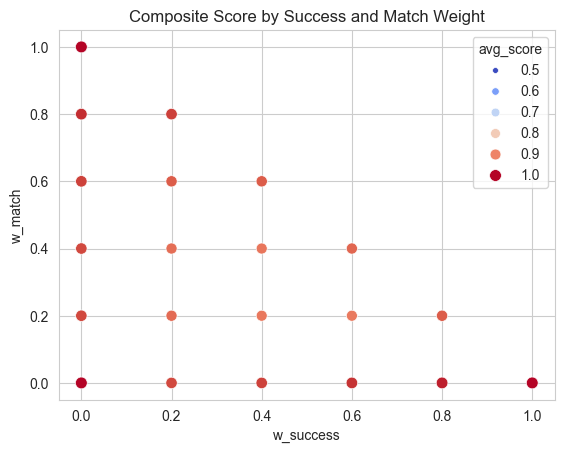

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=grid_df, x="w_success", y="w_match", size="avg_score", hue="avg_score", palette="coolwarm")
plt.title("Composite Score by Success and Match Weight")
plt.show()

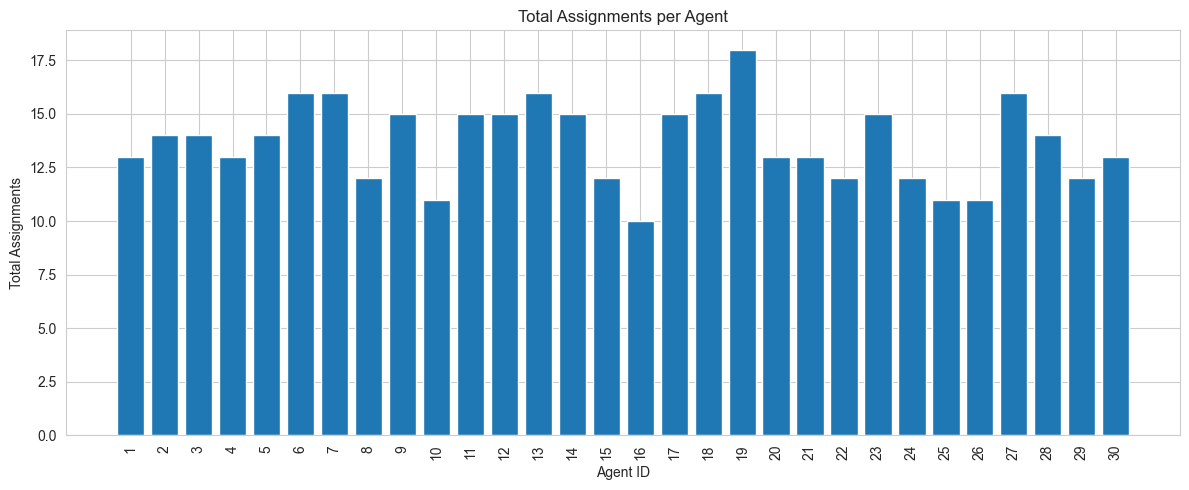

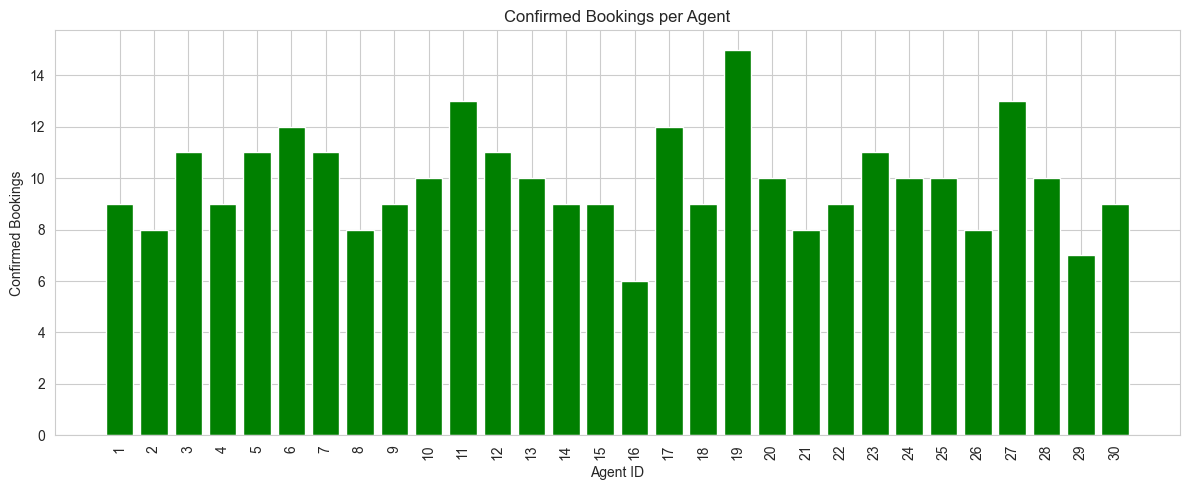

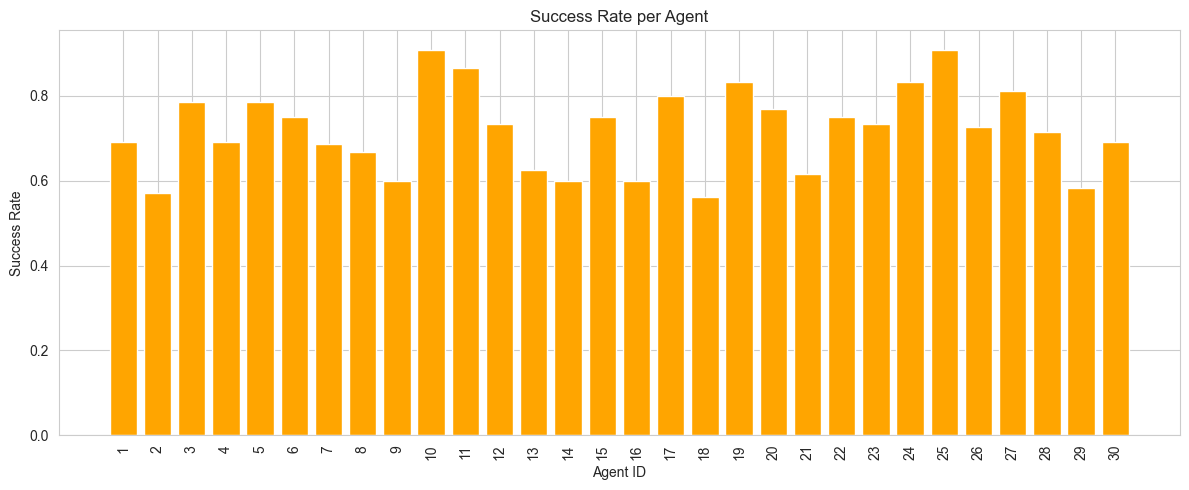

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Merge assignment history and bookings
merged = df_assignment.merge(df_bookings, on="AssignmentID", how="inner")

# Aggregate by agent
agent_stats = merged.groupby("AgentID").agg(
    Total_Assignments=("AssignmentID", "count"),
    Confirmed_Bookings=("BookingStatus", lambda x: (x == "Confirmed").sum())
).reset_index()

# Compute success rate
agent_stats["Success_Rate"] = agent_stats["Confirmed_Bookings"] / agent_stats["Total_Assignments"]

# Sort by AgentID
agent_stats = agent_stats.sort_values("AgentID")

# Plot 1: Total Assignments
plt.figure(figsize=(12, 5))
plt.bar(agent_stats["AgentID"].astype(str), agent_stats["Total_Assignments"])
plt.title("Total Assignments per Agent")
plt.xlabel("Agent ID")
plt.ylabel("Total Assignments")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot 2: Confirmed Bookings
plt.figure(figsize=(12, 5))
plt.bar(agent_stats["AgentID"].astype(str), agent_stats["Confirmed_Bookings"], color='green')
plt.title("Confirmed Bookings per Agent")
plt.xlabel("Agent ID")
plt.ylabel("Confirmed Bookings")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot 3: Success Rate
plt.figure(figsize=(12, 5))
plt.bar(agent_stats["AgentID"].astype(str), agent_stats["Success_Rate"], color='orange')
plt.title("Success Rate per Agent")
plt.xlabel("Agent ID")
plt.ylabel("Success Rate")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [24]:
# Merge assignment, bookings, and agent details
merged = df_assignment.merge(df_bookings, on="AssignmentID", how="inner")
merged = merged.merge(df_agents, on="AgentID", how="left")

# Filter to confirmed bookings only
confirmed = merged[merged["BookingStatus"] == "Confirmed"]

# Aggregate per agent
agent_metrics = confirmed.groupby("AgentID").agg({
    "TotalRevenue": "mean",
    "AverageCustomerServiceRating": "first"  # from agent info
}).rename(columns={"TotalRevenue": "AvgRevenue"}).reset_index()

# Calculate total assignments and success rate
assign_counts = merged.groupby("AgentID").agg(
    TotalAssignments=("AssignmentID", "count"),
    ConfirmedBookings=("BookingStatus", lambda x: (x == "Confirmed").sum())
).reset_index()
assign_counts["SuccessRate"] = assign_counts["ConfirmedBookings"] / assign_counts["TotalAssignments"]

# Merge with metrics
agent_summary = pd.merge(agent_metrics, assign_counts, on="AgentID")

# Keep relevant columns
agent_summary = agent_summary[[
    "AgentID", "AvgRevenue", "AverageCustomerServiceRating", "SuccessRate"
]]

agent_summary.head()

,AgentID,AvgRevenue,AverageCustomerServiceRating,SuccessRate
0,1,161111.111111,4.0,0.692308
1,2,164375.000000,4.0,0.571429
2,3,163181.818182,4.0,0.785714
3,4,153333.333333,4.0,0.692308
4,5,158181.818182,3.9,0.785714


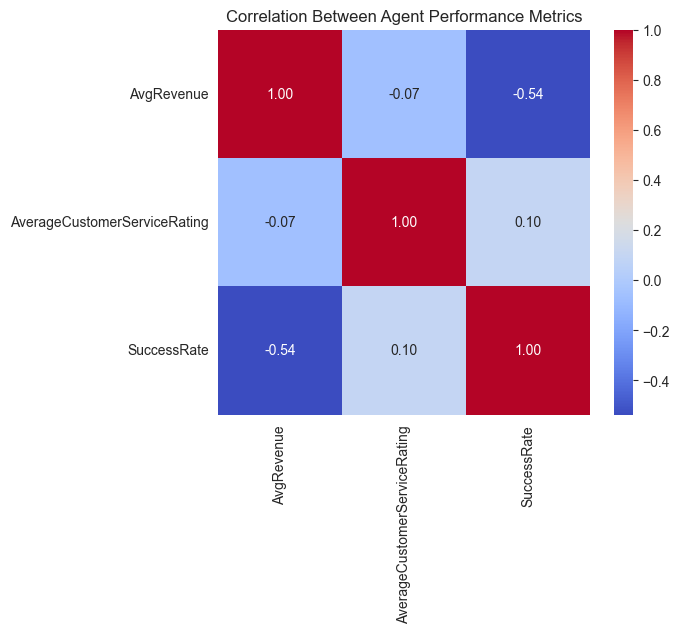

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr = agent_summary[["AvgRevenue", "AverageCustomerServiceRating", "SuccessRate"]].corr()

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Agent Performance Metrics")
plt.show()

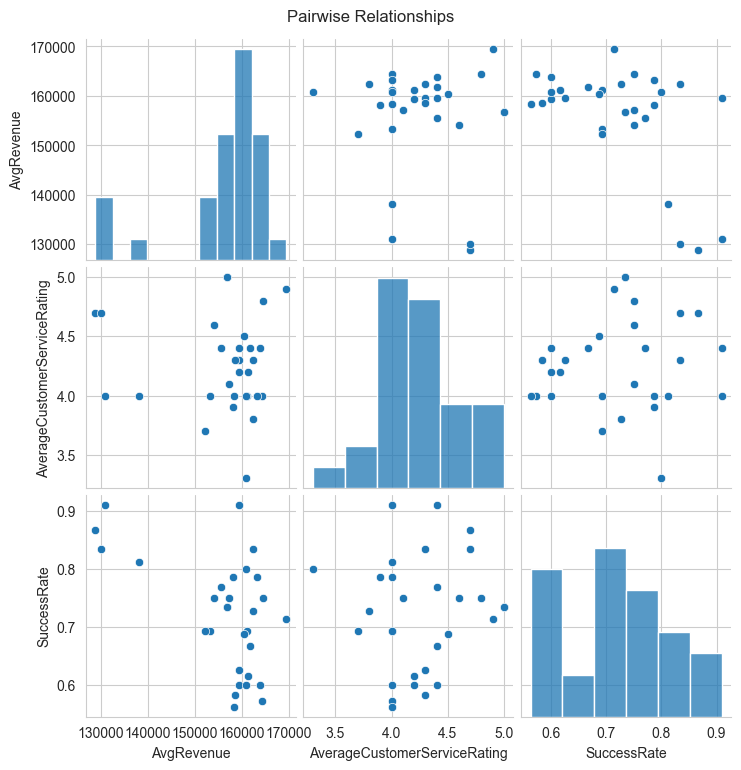

In [26]:
sns.pairplot(agent_summary[["AvgRevenue", "AverageCustomerServiceRating", "SuccessRate"]])
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()

In [27]:
# Step 1: Merge assignment + bookings
merged = df_assignment.merge(df_bookings, on='AssignmentID')

# Step 2: Merge in agent info (like ratings)
merged = merged.merge(df_agents[['AgentID', 'AverageCustomerServiceRating']], on='AgentID', how='left')

# Step 3: Group and summarize
agent_summary = (
    merged.groupby('AgentID')
    .agg(
        TotalAssignments=('AssignmentID', 'count'),
        ConfirmedBookings=('BookingStatus', lambda x: (x == 'Confirmed').sum()),
        TotalRevenue=('TotalRevenue', 'sum'),
        AverageCustomerServiceRating=('AverageCustomerServiceRating', 'first')
    )
    .reset_index()
)

# Step 4: Compute success rate
agent_summary['SuccessRate'] = agent_summary['ConfirmedBookings'] / agent_summary['TotalAssignments']

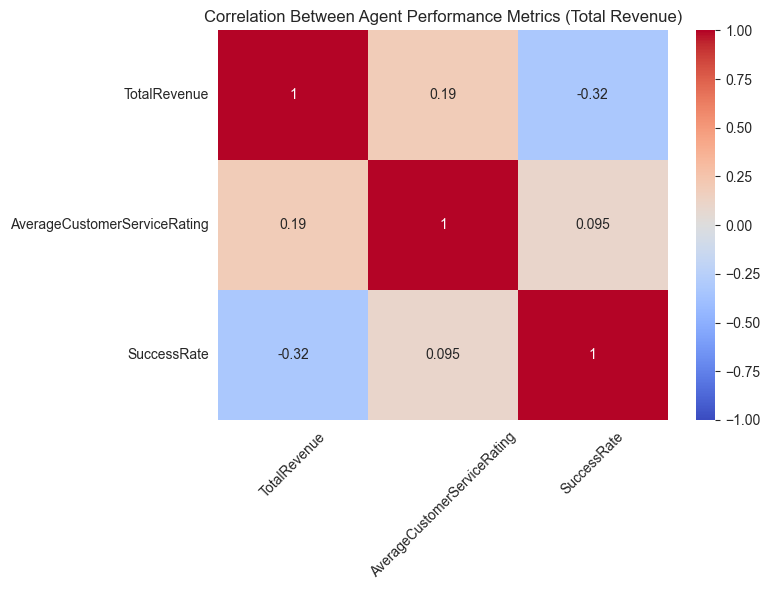

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics = agent_summary[['TotalRevenue', 'AverageCustomerServiceRating', 'SuccessRate']]
corr = metrics.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Between Agent Performance Metrics (Total Revenue)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

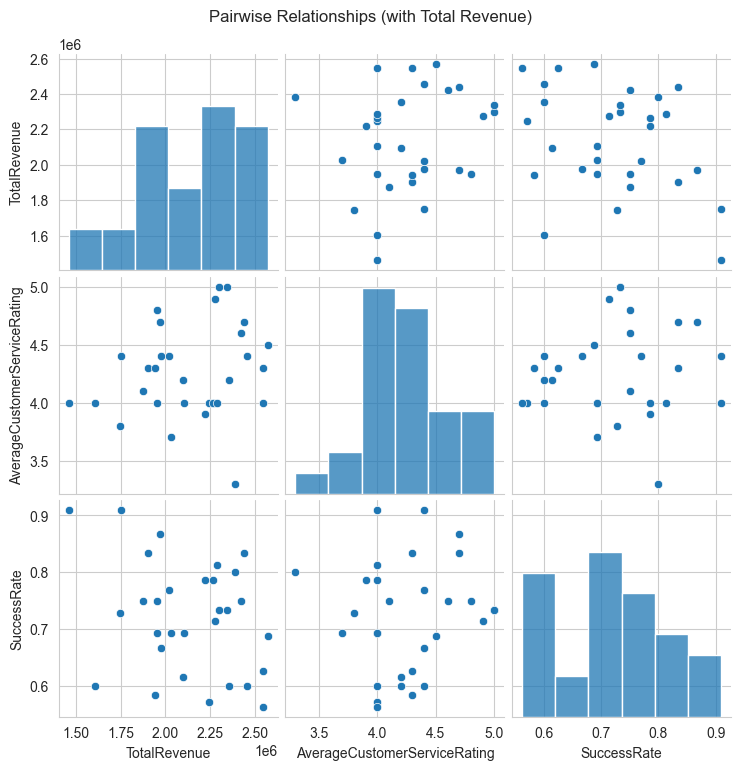

In [29]:
sns.pairplot(agent_summary[['TotalRevenue', 'AverageCustomerServiceRating', 'SuccessRate']])
plt.suptitle("Pairwise Relationships (with Total Revenue)", y=1.02)
plt.show()

In [31]:
print("assignment_history columns and dtypes:")
print(df_assignment.dtypes)
print("\n")

print("bookings columns and dtypes:")
print(df_bookings.dtypes)
print("\n")

print("space_travel_agents columns and dtypes:")
print(df_agents.dtypes)

assignment_history columns and dtypes:
AssignmentID            int64
AgentID                 int64
CustomerName           object
CommunicationMethod    object
LeadSource             object
AssignedDateTime       object
dtype: object


bookings columns and dtypes:
BookingID               int64
AssignmentID            int64
BookingCompleteDate    object
CancelledDate          object
Destination            object
Package                object
LaunchLocation         object
DestinationRevenue      int64
PackageRevenue          int64
TotalRevenue            int64
BookingStatus          object
dtype: object


space_travel_agents columns and dtypes:
AgentID                          object
FirstName                        object
LastName                         object
Email                            object
JobTitle                         object
DepartmentName                   object
ManagerName                      object
SpaceLicenseNumber               object
YearsOfService                

In [33]:
df_bookings['Success'] = (df_bookings['BookingStatus'] == 'Confirmed').astype(int)

# Convert AgentID to string in all DataFrames
df_assignment['AgentID'] = df_assignment['AgentID'].astype(str)
df_bookings['AssignmentID'] = df_bookings['AssignmentID'].astype(str)
df_assignment['AssignmentID'] = df_assignment['AssignmentID'].astype(str)
df_agents['AgentID'] = df_agents['AgentID'].astype(str)

# Merge bookings + assignment + agent
df_merged = df_bookings.merge(df_assignment, on='AssignmentID', how='left')
df_merged = df_merged.merge(df_agents, on='AgentID', how='left')

/var/folders/mn/5t8x6ck57719dt2pg7h0_xl40000gn/T/ipykernel_18322/3096709677.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SuccessRate', y=col, data=summary_df, palette='viridis')


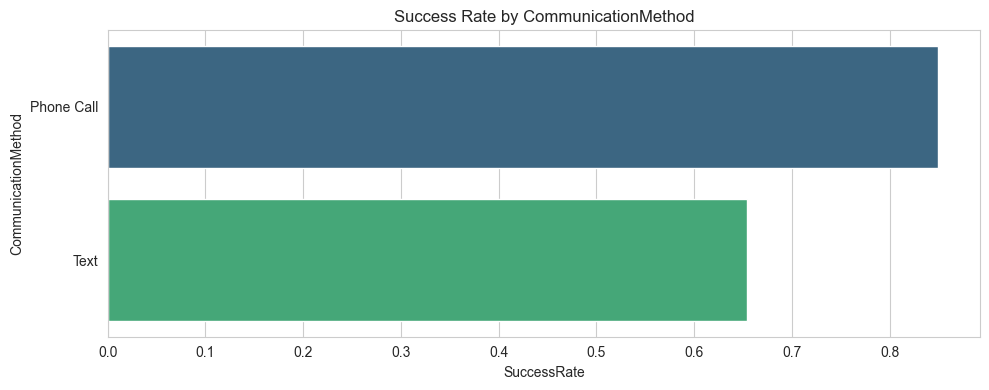

/var/folders/mn/5t8x6ck57719dt2pg7h0_xl40000gn/T/ipykernel_18322/3096709677.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SuccessRate', y=col, data=summary_df, palette='viridis')


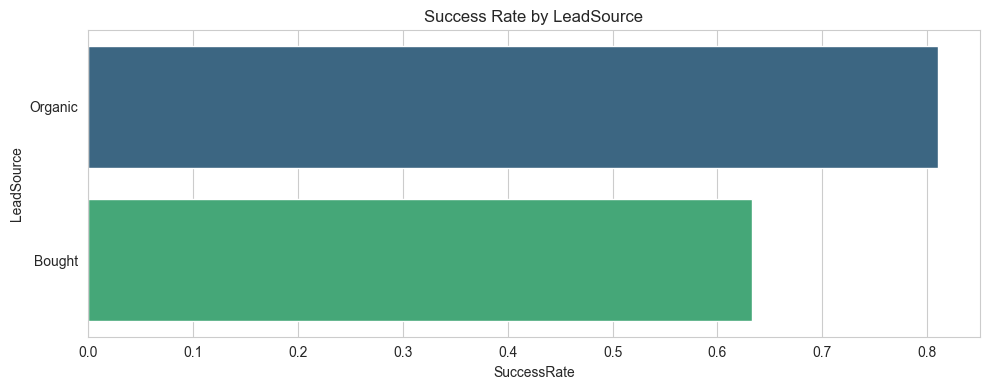

/var/folders/mn/5t8x6ck57719dt2pg7h0_xl40000gn/T/ipykernel_18322/3096709677.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SuccessRate', y=col, data=summary_df, palette='viridis')


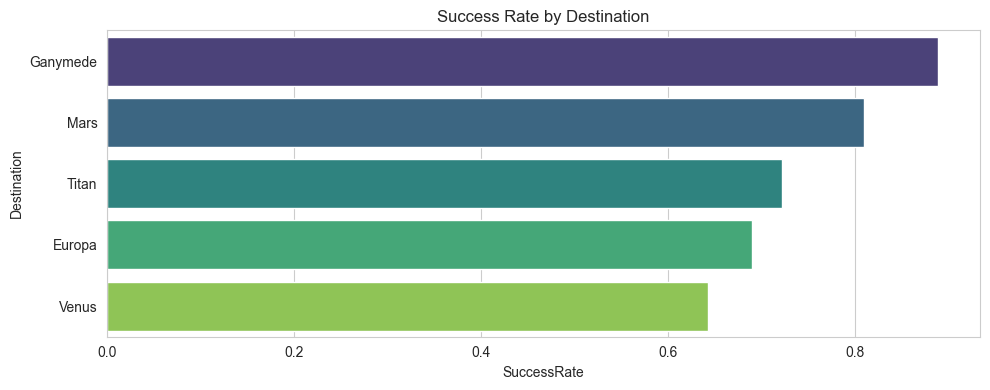

/var/folders/mn/5t8x6ck57719dt2pg7h0_xl40000gn/T/ipykernel_18322/3096709677.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SuccessRate', y=col, data=summary_df, palette='viridis')


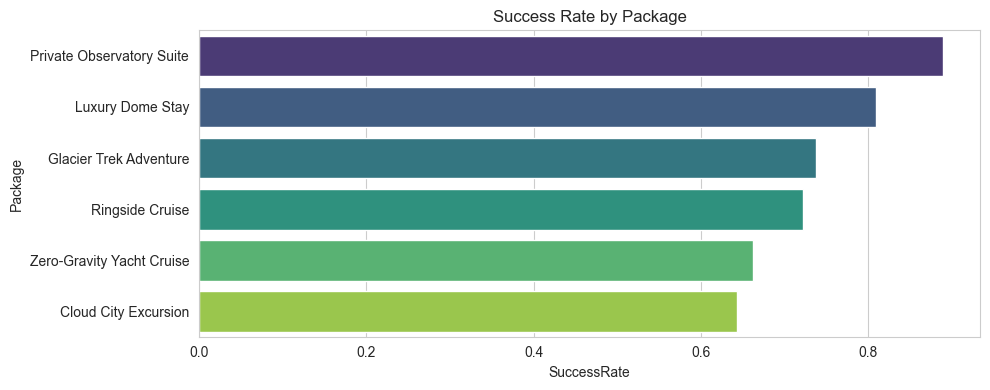

/var/folders/mn/5t8x6ck57719dt2pg7h0_xl40000gn/T/ipykernel_18322/3096709677.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SuccessRate', y=col, data=summary_df, palette='viridis')


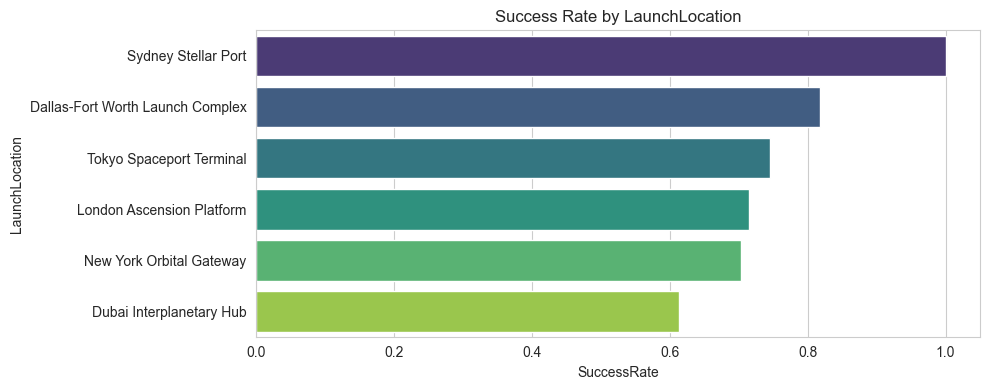

/var/folders/mn/5t8x6ck57719dt2pg7h0_xl40000gn/T/ipykernel_18322/3096709677.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SuccessRate', y=col, data=summary_df, palette='viridis')


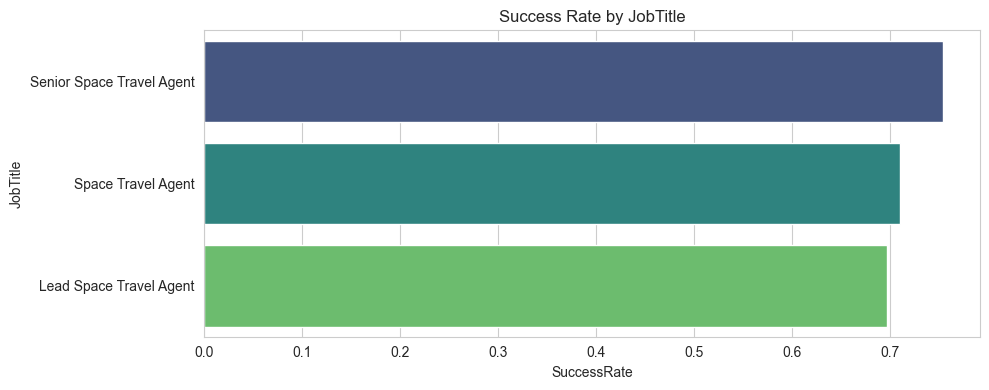

/var/folders/mn/5t8x6ck57719dt2pg7h0_xl40000gn/T/ipykernel_18322/3096709677.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SuccessRate', y=col, data=summary_df, palette='viridis')


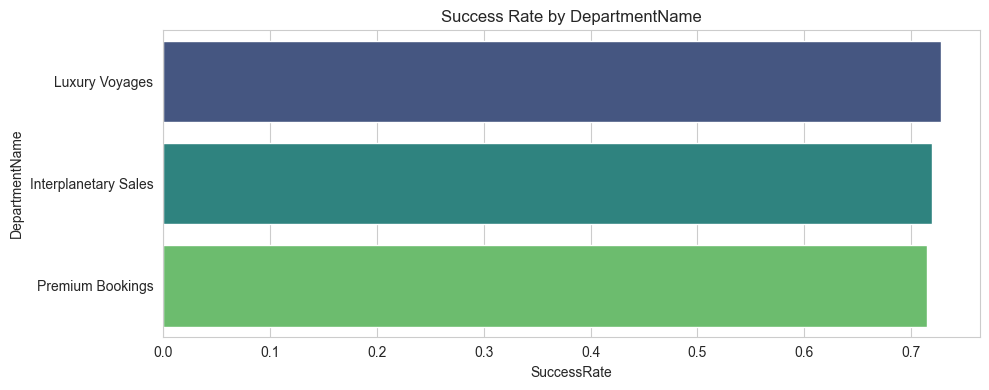

/var/folders/mn/5t8x6ck57719dt2pg7h0_xl40000gn/T/ipykernel_18322/3096709677.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SuccessRate', y=col, data=summary_df, palette='viridis')


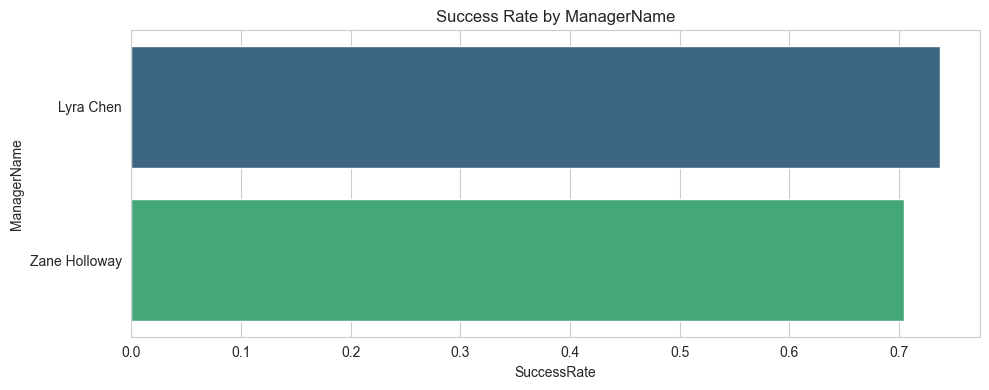

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Ensure AgentID types match
df_assignment['AgentID'] = df_assignment['AgentID'].astype(str)
df_agents['AgentID'] = df_agents['AgentID'].astype(str)

# Step 2: Merge all data into one dataframe
df_merged = (
    df_bookings
    .merge(df_assignment, on='AssignmentID', how='left')
    .merge(
        df_agents[
            ['AgentID', 'AverageCustomerServiceRating', 'JobTitle', 'DepartmentName', 'ManagerName']
        ],
        on='AgentID',
        how='left'
    )
)

# Step 3: Add Success as binary column
df_merged['Success'] = (df_merged['BookingStatus'] == 'Confirmed').astype(int)

# Step 4: Define categorical columns to analyze
categorical_cols = [
    'CommunicationMethod', 
    'LeadSource',
    'Destination', 
    'Package', 
    'LaunchLocation',
    'JobTitle', 
    'DepartmentName', 
    'ManagerName'
]

# Step 5: Summary function
def summarize_by_category(df, category):
    return (
        df.groupby(category)
        .agg(
            SuccessRate=('Success', 'mean'),
            AvgRevenue=('TotalRevenue', 'mean'),
            AvgCustomerRating=('AverageCustomerServiceRating', 'mean'),
            Count=('AssignmentID', 'count')
        )
        .sort_values(by='SuccessRate', ascending=False)
        .reset_index()
    )

# Step 6: Run summaries and plot
summaries = {}
for col in categorical_cols:
    summary_df = summarize_by_category(df_merged, col)
    summaries[col] = summary_df

    plt.figure(figsize=(10, 4))
    sns.barplot(x='SuccessRate', y=col, data=summary_df, palette='viridis')
    plt.title(f'Success Rate by {col}')
    plt.tight_layout()
    plt.show()

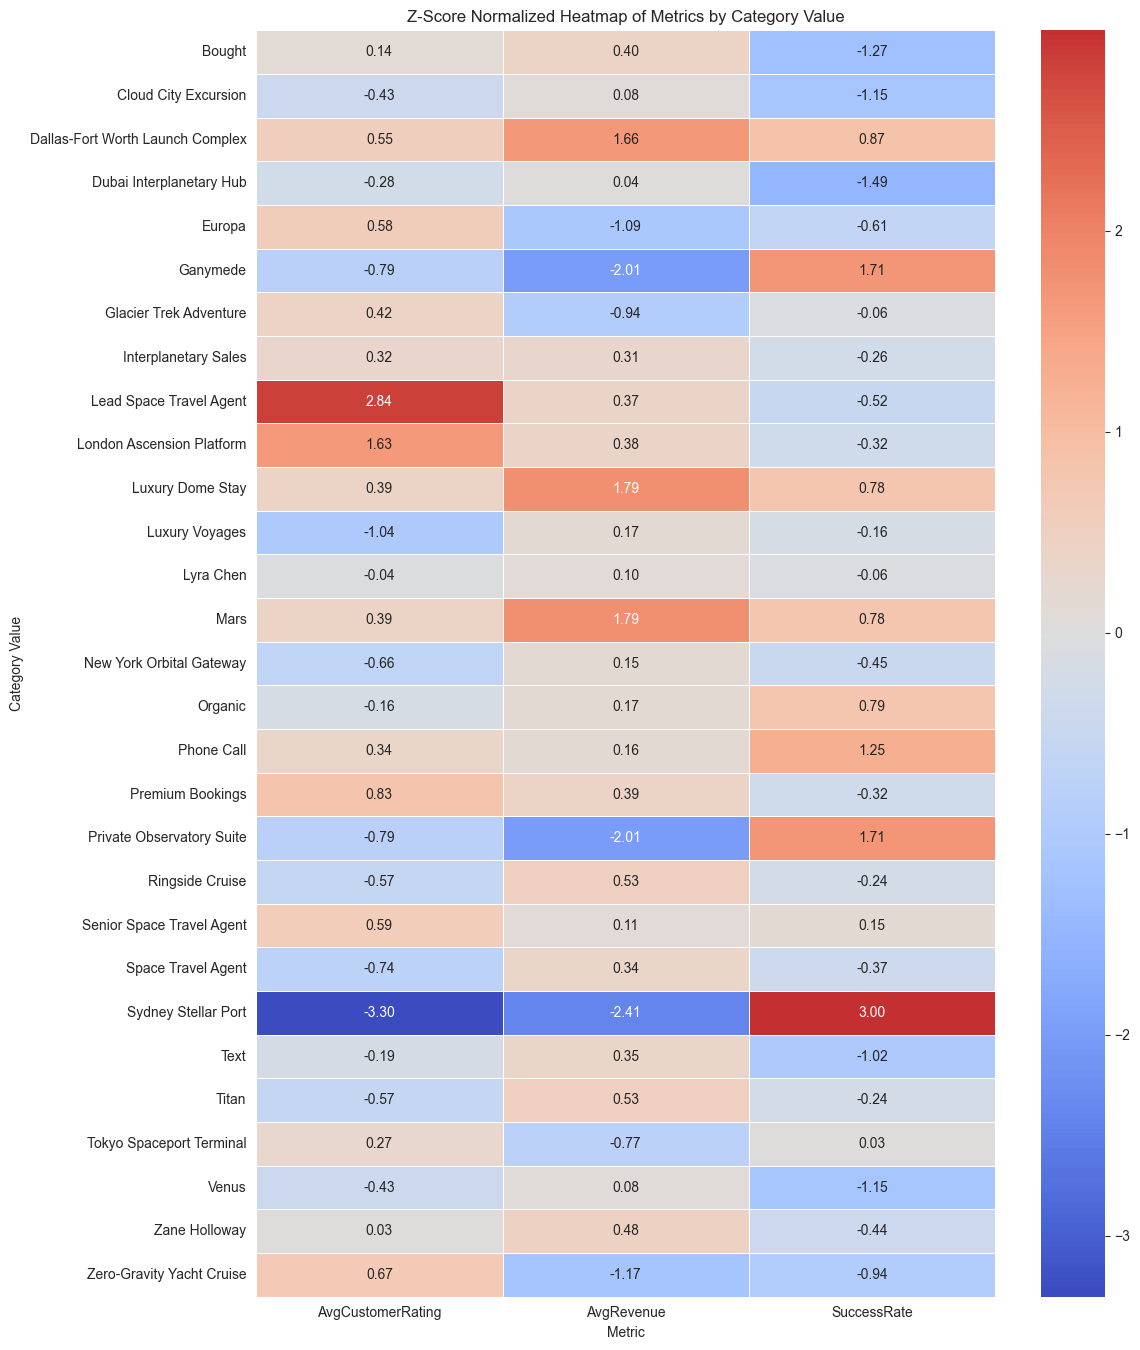

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Collect summary metrics across categorical values
heatmap_data = []

for col in categorical_cols:
    summary_df = summarize_by_category(df_merged, col)
    for _, row in summary_df.iterrows():
        heatmap_data.append({
            'Category': col,
            'Value': row[col],
            'SuccessRate': row['SuccessRate'],
            'AvgRevenue': row['AvgRevenue'],
            'AvgCustomerRating': row['AvgCustomerRating']
        })

# Build DataFrame
heatmap_df = pd.DataFrame(heatmap_data)

# Melt into long format for easier z-score normalization
melted = heatmap_df.melt(id_vars=['Category', 'Value'], 
                         value_vars=['SuccessRate', 'AvgRevenue', 'AvgCustomerRating'],
                         var_name='Metric',
                         value_name='ValueScore')

# Normalize using z-score within each metric
melted['ZScore'] = melted.groupby('Metric')['ValueScore'].transform(zscore)

# Pivot to plot
pivot = melted.pivot(index='Value', columns='Metric', values='ZScore')

# Plot heatmap
plt.figure(figsize=(12, len(pivot) * 0.4 + 2))
sns.heatmap(pivot, annot=True, center=0, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Z-Score Normalized Heatmap of Metrics by Category Value")
plt.xlabel("Metric")
plt.ylabel("Category Value")
plt.tight_layout()
plt.show()

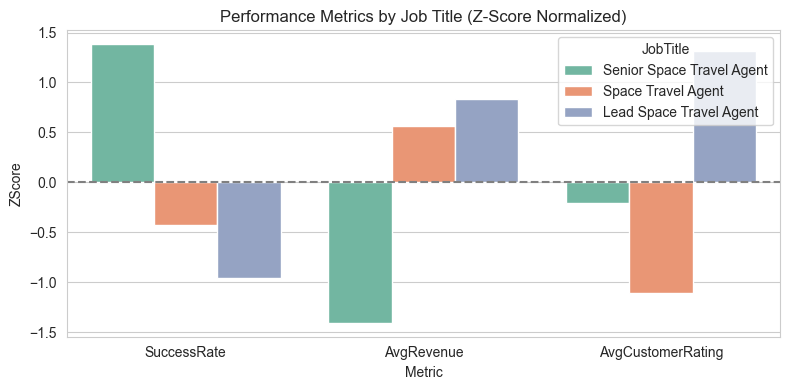

In [41]:
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt

# Group and summarize by YearsOfService
service_summary = (
    df_merged.groupby('YearsOfService')
    .agg(
        SuccessRate=('Success', 'mean'),
        AvgRevenue=('TotalRevenue', 'mean'),
        AvgCustomerRating=('AverageCustomerServiceRating', 'mean'),
        Count=('AssignmentID', 'count')
    )
    .reset_index()
)

# Filter out very low volume if needed (optional)
service_summary = service_summary[service_summary['Count'] > 5]

# Normalize metrics with z-score
metrics = ['SuccessRate', 'AvgRevenue', 'AvgCustomerRating']
for metric in metrics:
    service_summary[f'{metric}_z'] = zscore(service_summary[metric])

# Melt for plotting
service_melted = service_summary.melt(id_vars='YearsOfService', 
                                      value_vars=[f'{m}_z' for m in metrics], 
                                      var_name='Metric', 
                                      value_name='ZScore')

# Clean up names
service_melted['Metric'] = service_melted['Metric'].str.replace('_z', '')

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=service_melted, x='YearsOfService', y='ZScore', hue='Metric', marker='o')
plt.title("Performance Metrics vs. Years of Service (Z-Score Normalized)")
plt.axhline(0, linestyle='--', color='gray')
plt.tight_layout()
plt.show()

                   YearsOfService  SuccessRate  AvgRevenue  AvgCustomerRating
YearsOfService           1.000000    -0.051718    0.046491           0.267601
SuccessRate             -0.051718     1.000000   -0.584381           0.095278
AvgRevenue               0.046491    -0.584381    1.000000          -0.119186
AvgCustomerRating        0.267601     0.095278   -0.119186           1.000000


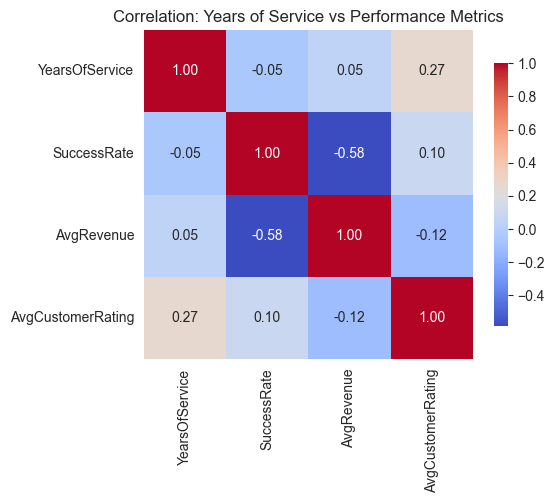

In [45]:
# Step 1: Merge necessary data
df_merged = (
    df_bookings
    .merge(df_assignment, on='AssignmentID', how='left')
    .merge(
        df_agents[
            ['AgentID', 'YearsOfService', 'AverageCustomerServiceRating', 'JobTitle', 'DepartmentName']
        ],
        on='AgentID',
        how='left'
    )
)

# Step 2: Add Success flag
df_merged['Success'] = (df_merged['BookingStatus'] == 'Confirmed').astype(int)

# Step 3: Aggregate to agent level
agent_perf = (
    df_merged.groupby('AgentID')
    .agg(
        YearsOfService=('YearsOfService', 'first'),
        SuccessRate=('Success', 'mean'),
        AvgRevenue=('TotalRevenue', 'mean'),
        AvgCustomerRating=('AverageCustomerServiceRating', 'first'),
        NumAssignments=('AssignmentID', 'count')
    )
    .dropna()
    .reset_index()
)

# Step 4: Compute and display correlation matrix
correlation_matrix = agent_perf[['YearsOfService', 'SuccessRate', 'AvgRevenue', 'AvgCustomerRating']].corr()
print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
correlation_matrix = agent_perf[['YearsOfService', 'SuccessRate', 'AvgRevenue', 'AvgCustomerRating']].corr()

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": 0.8})
plt.title('Correlation: Years of Service vs Performance Metrics')
plt.tight_layout()
plt.show()

In [66]:
import duckdb
import pandas as pd

# Connect to DuckDB
con = duckdb.connect(database=':memory:')

# Load data from .txt SQL-formatted files
with open("assignment_history SQL Table.txt", "r") as f:
    con.execute(f.read())

with open("bookings SQL Table.txt", "r") as f:
    con.execute(f.read())

with open("space_travel_agents SQL Table.txt", "r") as f:
    con.execute(f.read())

# Create agent summary view
con.execute("""
DROP VIEW IF EXISTS agent_summary;
CREATE VIEW agent_summary AS
SELECT
    st.AgentID,
    st.FirstName,
    st.LastName,
    st.AverageCustomerServiceRating,
    st.YearsOfService,
    COUNT(ah.AssignmentID) AS TotalAssignments,
    COALESCE(SUM(CASE WHEN b.BookingStatus = 'Confirmed' THEN 1 ELSE 0 END),0) AS ConfirmedBookings,
    COALESCE(SUM(CASE WHEN b.BookingStatus = 'Cancelled' THEN 1 ELSE 0 END),0) AS CancelledBookings,
    COALESCE(SUM(CASE WHEN b.BookingStatus = 'Pending' THEN 1 ELSE 0 END),0) AS PendingBookings,
    CASE WHEN COUNT(ah.AssignmentID) > 0
         THEN SUM(CASE WHEN b.BookingStatus = 'Confirmed' THEN 1 ELSE 0 END) * 1.0 / COUNT(ah.AssignmentID)
         ELSE 0 END AS ConversionRate,
    CASE WHEN SUM(CASE WHEN b.BookingStatus = 'Confirmed' THEN 1 ELSE 0 END) > 0
         THEN SUM(CASE WHEN b.BookingStatus = 'Confirmed' THEN b.TotalRevenue ELSE 0 END) /
              SUM(CASE WHEN b.BookingStatus = 'Confirmed' THEN 1 ELSE 0 END)
         ELSE 0 END AS AvgRevenuePerBooking
FROM space_travel_agents AS st
LEFT JOIN assignment_history AS ah ON ah.AgentID = st.AgentID
LEFT JOIN bookings AS b ON b.AssignmentID = ah.AssignmentID
GROUP BY st.AgentID, st.FirstName, st.LastName, st.AverageCustomerServiceRating, st.YearsOfService
""")

# Define and run agent ranking function
def get_agent_ranking(communication_method, lead_source, destination, launch_location):
    query = f"""
    WITH
        comm AS (
            SELECT ah.AgentID,
                   SUM(CASE WHEN b.BookingStatus = 'Confirmed' THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS CommConversionRate
            FROM assignment_history ah
            LEFT JOIN bookings b ON b.AssignmentID = ah.AssignmentID
            WHERE ah.CommunicationMethod = '{communication_method}'
            GROUP BY ah.AgentID
        ),
        lead_src AS (
            SELECT ah.AgentID,
                   SUM(CASE WHEN b.BookingStatus = 'Confirmed' THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS LeadConversionRate
            FROM assignment_history ah
            LEFT JOIN bookings b ON b.AssignmentID = ah.AssignmentID
            WHERE ah.LeadSource = '{lead_source}'
            GROUP BY ah.AgentID
        ),
        dest_rev AS (
            SELECT ah.AgentID,
                   SUM(CASE WHEN b.BookingStatus = 'Confirmed' THEN b.TotalRevenue ELSE 0 END) * 1.0 /
                   NULLIF(SUM(CASE WHEN b.BookingStatus = 'Confirmed' THEN 1 ELSE 0 END), 0) AS DestinationAvgRevenue
            FROM assignment_history ah
            LEFT JOIN bookings b ON b.AssignmentID = ah.AssignmentID
            WHERE b.Destination = '{destination}'
            GROUP BY ah.AgentID
        ),
        launch_conv AS (
            SELECT ah.AgentID,
                   SUM(CASE WHEN b.BookingStatus = 'Confirmed' THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS LaunchConversionRate
            FROM assignment_history ah
            LEFT JOIN bookings b ON b.AssignmentID = ah.AssignmentID
            WHERE b.LaunchLocation = '{launch_location}'
            GROUP BY ah.AgentID
        )

    SELECT
        s.AgentID,
        s.FirstName,
        s.LastName,
        (
            0.30 * (s.AverageCustomerServiceRating / 5.0) +
            0.25 * s.ConversionRate +
            0.25 * (s.AvgRevenuePerBooking / 200000.0) +
            0.10 * (s.YearsOfService / 20.0) +
            0.05 * COALESCE(c.CommConversionRate, s.ConversionRate) +
            0.05 * COALESCE(ls.LeadConversionRate, s.ConversionRate) +
            0.05 * (COALESCE(d.DestinationAvgRevenue, s.AvgRevenuePerBooking) / 200000.0) +
            0.05 * COALESCE(l.LaunchConversionRate, s.ConversionRate)
        ) AS Score
    FROM agent_summary s
    LEFT JOIN comm c ON s.AgentID = c.AgentID
    LEFT JOIN lead_src ls ON s.AgentID = ls.AgentID
    LEFT JOIN dest_rev d ON s.AgentID = d.AgentID
    LEFT JOIN launch_conv l ON s.AgentID = l.AgentID
    ORDER BY Score DESC
    """
    return con.execute(query).df()

# Example call
get_agent_ranking(
    communication_method="Text",
    lead_source="Organic",
    destination="Mars",
    launch_location="Dallas-Fort Worth Launch Complex"
)

,AgentID,FirstName,LastName,Score
0,24,Phoebe,Diaz,0.902258
1,6,Soren,Baker,0.893702
2,22,Juno,Brooks,0.872722
3,12,Nia,Ramirez,0.871301
4,19,Calypso,White,0.869316
5,27,Ronan,Young,0.849259
6,28,Mila,Reed,0.846808
7,23,Cassian,Ward,0.842273
8,25,Enzo,Nguyen,0.841099
9,11,Elias,Walker,0.837790


In [67]:
# Step 1: Prepare backtest data by joining agent + assignment + booking info
df_backtest = con.execute("""
    SELECT
        b.BookingID,
        b.AssignmentID,
        b.BookingStatus,
        b.TotalRevenue,
        b.Destination,
        b.LaunchLocation,
        ah.AgentID,
        ah.CommunicationMethod,
        ah.LeadSource,
        a.AverageCustomerServiceRating,
        a.YearsOfService,
        COALESCE(b.TotalRevenue, 0) AS Revenue
    FROM bookings b
    LEFT JOIN assignment_history ah ON b.AssignmentID = ah.AssignmentID
    LEFT JOIN space_travel_agents a ON ah.AgentID = a.AgentID
""").df()

# Step 2: For each row, compute the "Score" based on the same weighted formula
def score_row(row):
    # Dummy fallback conversion rates
    fallback_conv = 0.5

    # Normalized inputs
    rating = row["AverageCustomerServiceRating"] / 5.0 if pd.notnull(row["AverageCustomerServiceRating"]) else 0
    years  = row["YearsOfService"] / 20.0 if pd.notnull(row["YearsOfService"]) else 0
    revenue = row["Revenue"] / 200000.0

    # Conversion rate approximations (or you can pre-calculate agent-level summaries for accuracy)
    conv_rate = fallback_conv
    comm_conv = fallback_conv
    lead_conv = fallback_conv
    dest_rev = revenue
    launch_conv = fallback_conv

    # Final weighted score (same as SQL logic)
    score = (
        0.30 * rating +
        0.25 * conv_rate +
        0.25 * revenue +
        0.10 * years +
        0.05 * comm_conv +
        0.05 * lead_conv +
        0.05 * dest_rev +
        0.05 * launch_conv
    )
    return score

df_backtest["Score"] = df_backtest.apply(score_row, axis=1)

/var/folders/mn/5t8x6ck57719dt2pg7h0_xl40000gn/T/ipykernel_18322/804021317.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_backtest, x="BookingStatus", y="Score", palette="Set2")


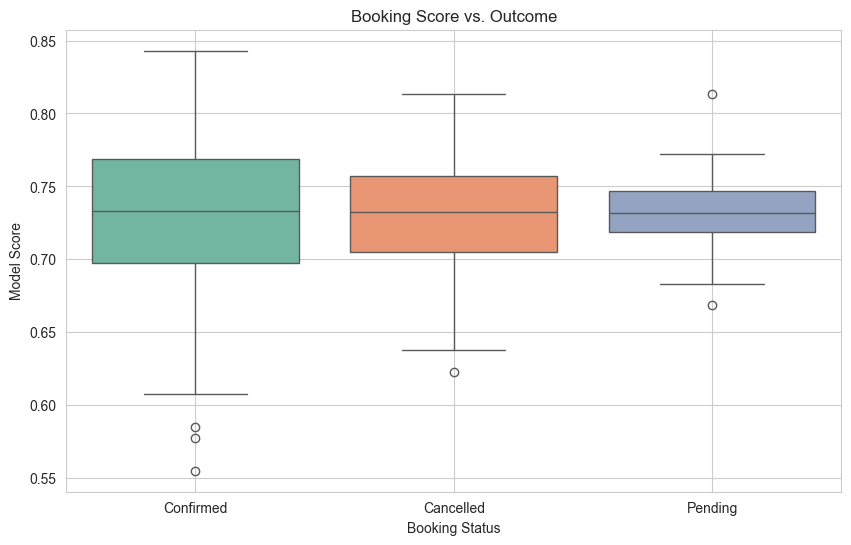

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Score distribution by BookingStatus
plt.figure(figsize=(10,6))
sns.boxplot(data=df_backtest, x="BookingStatus", y="Score", palette="Set2")
plt.title("Booking Score vs. Outcome")
plt.ylabel("Model Score")
plt.xlabel("Booking Status")
plt.grid(True)
plt.show()

/var/folders/mn/5t8x6ck57719dt2pg7h0_xl40000gn/T/ipykernel_18322/744594798.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_backtest, x="BookingStatus", y="Score", jitter=True, alpha=0.6, palette="Set2")


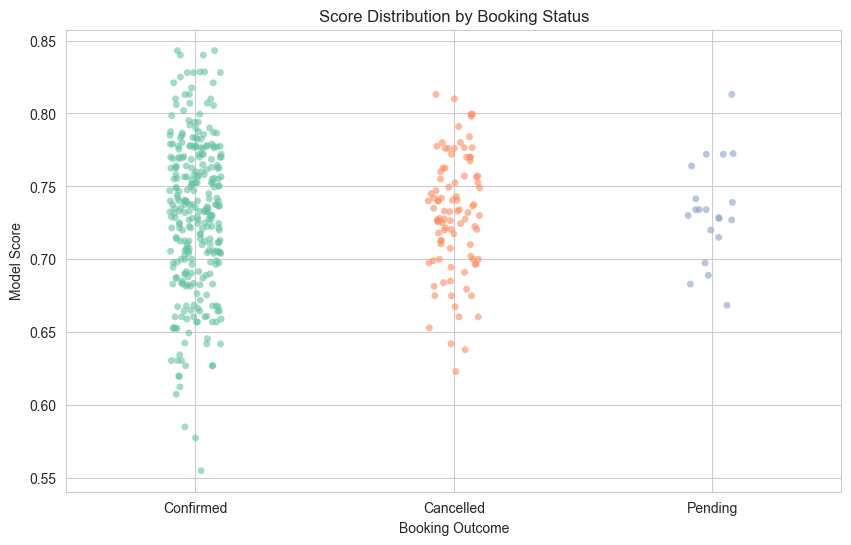

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.stripplot(data=df_backtest, x="BookingStatus", y="Score", jitter=True, alpha=0.6, palette="Set2")
plt.title("Score Distribution by Booking Status")
plt.ylabel("Model Score")
plt.xlabel("Booking Outcome")
plt.grid(True)
plt.show()

/var/folders/mn/5t8x6ck57719dt2pg7h0_xl40000gn/T/ipykernel_18322/2296125561.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=df_backtest, x="BookingStatus", y="Score", palette="Set2", size=4)


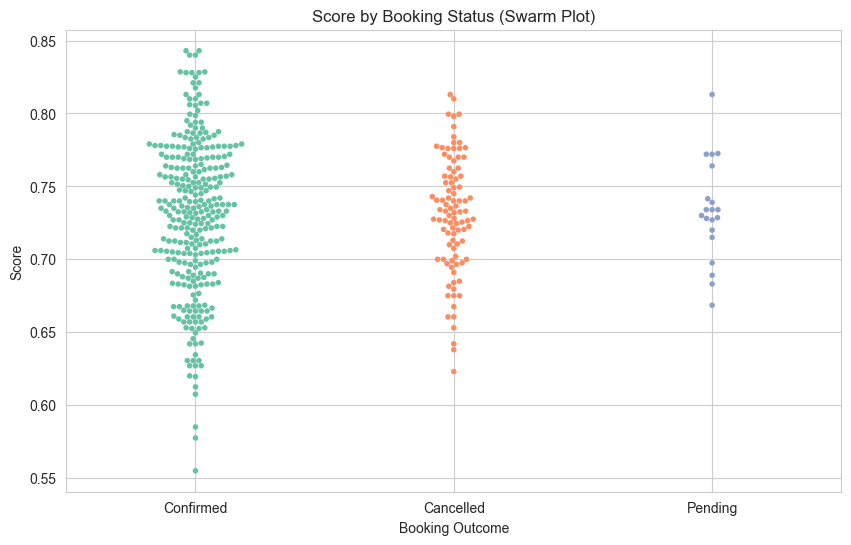

In [70]:
plt.figure(figsize=(10, 6))
sns.swarmplot(data=df_backtest, x="BookingStatus", y="Score", palette="Set2", size=4)
plt.title("Score by Booking Status (Swarm Plot)")
plt.ylabel("Score")
plt.xlabel("Booking Outcome")
plt.grid(True)
plt.show()

In [71]:
df_backtest["IsConfirmed"] = df_backtest["BookingStatus"].apply(lambda x: 1 if x == "Confirmed" else 0)

df_backtest[[
    "Score",
    "Revenue",
    "IsConfirmed",
    "AverageCustomerServiceRating"
]].corr()

,Score,Revenue,IsConfirmed,AverageCustomerServiceRating
Score,1.000000,0.606326,-0.010927,0.579145
Revenue,0.606326,1.000000,-0.031297,-0.068290
IsConfirmed,-0.010927,-0.031297,1.000000,0.022377
AverageCustomerServiceRating,0.579145,-0.068290,0.022377,1.000000


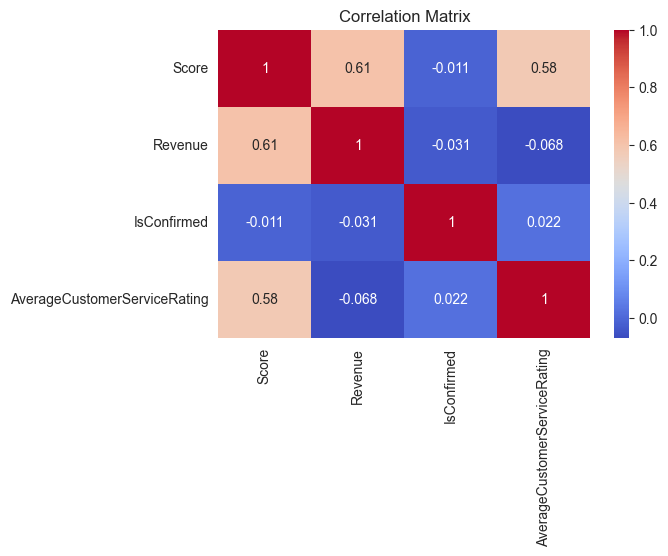

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(df_backtest[["Score", "Revenue", "IsConfirmed", "AverageCustomerServiceRating"]].corr(),
            annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Correlations with IsConfirmed:
IsConfirmed        1.000000
Norm_Rating        0.022377
Norm_Years        -0.003566
Score             -0.010927
Revenue           -0.031297
Norm_Revenue      -0.031297
Norm_DestRev      -0.031297
Norm_CommConv           NaN
Norm_LeadConv           NaN
Norm_LaunchConv         NaN
Name: IsConfirmed, dtype: float64


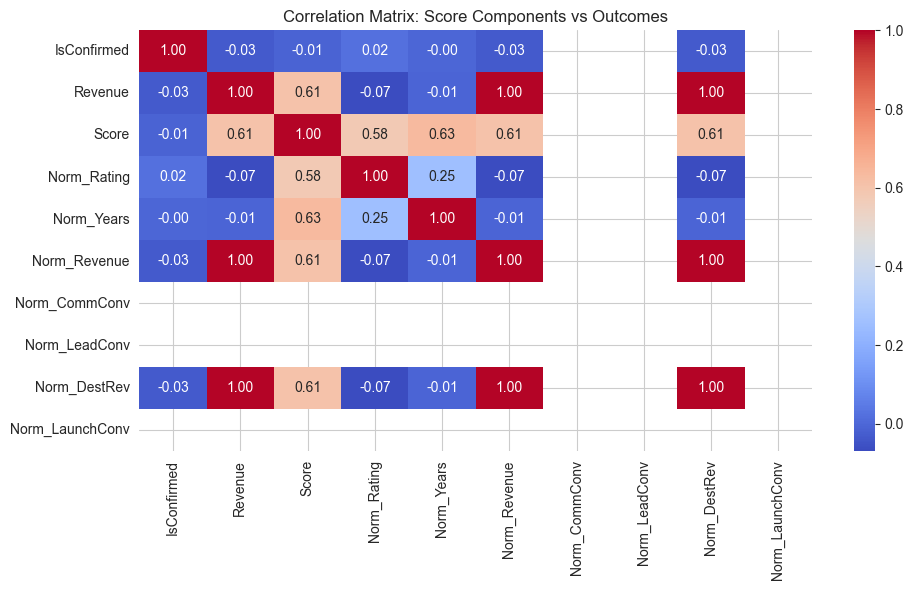

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Prepare target variable and defaults
df_backtest["IsConfirmed"] = df_backtest["BookingStatus"].apply(lambda x: 1 if x == "Confirmed" else 0)
fallback_conv = 0.5
revenue_max = 200000.0

# Step 2: Compute normalized score components
df_backtest["Norm_Rating"]         = df_backtest["AverageCustomerServiceRating"] / 5.0
df_backtest["Norm_Years"]          = df_backtest["YearsOfService"] / 20.0
df_backtest["Norm_Revenue"]        = df_backtest["Revenue"] / revenue_max
df_backtest["CommConversionRate"]  = fallback_conv  # Placeholder if no joined data
df_backtest["LeadConversionRate"]  = fallback_conv
df_backtest["DestinationRevenue"]  = df_backtest["Revenue"]
df_backtest["LaunchConversionRate"]= fallback_conv

df_backtest["Norm_CommConv"]       = df_backtest["CommConversionRate"]
df_backtest["Norm_LeadConv"]       = df_backtest["LeadConversionRate"]
df_backtest["Norm_DestRev"]        = df_backtest["DestinationRevenue"] / revenue_max
df_backtest["Norm_LaunchConv"]     = df_backtest["LaunchConversionRate"]

# Step 3: Correlation matrix
corr_df = df_backtest[[
    "IsConfirmed",
    "Revenue",
    "Score",
    "Norm_Rating",
    "Norm_Years",
    "Norm_Revenue",
    "Norm_CommConv",
    "Norm_LeadConv",
    "Norm_DestRev",
    "Norm_LaunchConv"
]].corr()

# Print relevant correlations with IsConfirmed
print("Correlations with IsConfirmed:")
print(corr_df["IsConfirmed"].sort_values(ascending=False))

# Step 4: Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Score Components vs Outcomes")
plt.tight_layout()
plt.show()

In [75]:
# Step 1: Ensure AgentID types match
df_assignment['AgentID'] = df_assignment['AgentID'].astype(str)
df_agents['AgentID'] = df_agents['AgentID'].astype(str)

# Step 2: Merge data
df_merged = (
    df_bookings
    .merge(df_assignment, on='AssignmentID', how='left')
    .merge(df_agents[['AgentID', 'AverageCustomerServiceRating']], on='AgentID', how='left')
)

# Step 3: Add success flag
df_merged['Success'] = (df_merged['BookingStatus'] == 'Confirmed').astype(int)

# Step 4: Summarize load and outcomes
agent_load = (
    df_merged.groupby('AgentID')
    .agg(
        Load=('AssignmentID', 'count'),
        SuccessRate=('Success', 'mean'),
        Confirmed=('Success', 'sum'),
        Cancelled=('BookingStatus', lambda x: (x == 'Cancelled').sum()),
        Pending=('BookingStatus', lambda x: (x == 'Pending').sum())
    )
    .reset_index()
)

# Step 5: View or visualize
agent_load.sort_values('Load', ascending=False).head(10)

# Calculate and print the correlation between Load and SuccessRate
correlation = agent_load['Load'].corr(agent_load['SuccessRate'])
print(f"Correlation between Load and Success Rate: {correlation:.3f}")

Correlation between Load and Success Rate: -0.063
